# Super resolución de imágenes usando redes convolucionales
**Autores**

* Oleg Sovero
* Jose Huertas
* Gustavo Rojas
* Alfredo Tarazona

In [4]:
# Fuentes de información:
# https://keras.io/examples/vision/super_resolution_sub_pixel/
# https://blog.paperspace.com/image-super-resolution/

In [5]:
# Importamos las librerias
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display


In [6]:
# Montar en el directorio de drive, asi no gastamos mucha ram
from google.colab import drive
drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Dataset/SIR_backup"
%cd $working_dir

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1HWgELbfAzgbCmGvQOJLuIEqQ7rDlmM_v/Dataset/SIR_backup


In [7]:
%ls $working_dir

0-highres.png      1-prediction.png  9-lowres.png
0-lowres.png       2-highres.png     9-prediction.png
0-prediction.png   2-lowres.png      checkpoint
10-highres.png     2-prediction.png  epoch-0-prediction.png
10-lowres.png      3-highres.png     epoch-100-prediction.png
10-prediction.png  3-lowres.png      epoch-120-prediction.png
11-highres.png     3-prediction.png  epoch-140-prediction.png
11-lowres.png      4-highres.png     epoch-160-prediction.png
11-prediction.png  4-lowres.png      epoch-180-prediction.png
12-highres.png     4-prediction.png  epoch-20-prediction.png
12-lowres.png      5-highres.png     epoch-40-prediction.png
12-prediction.png  5-lowres.png      epoch-60-prediction.png
13-highres.png     5-prediction.png  epoch-80-prediction.png
13-lowres.png      6-highres.png     images_out/
13-prediction.png  6-lowres.png      model_plot.png
14-highres.png     6-prediction.png  Temp/
14-lowres.png      7-highres.png     Temp.data-00000-of-00001
14-prediction.png  7-lowres.

In [8]:
train_path = working_dir + '/Training_Set'
valid_path = working_dir + '/Validation_Set'

In [9]:
# Mis cambios
crop_size = 300
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 5

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 68 files belonging to 1 classes.
Using 55 files for training.
Found 16 files belonging to 1 classes.
Using 3 files for validation.


Escalamos las imagenes

In [10]:
# Escalamos las imágenes para que el valor de cada píxel este en el rango de 0 y 1
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)


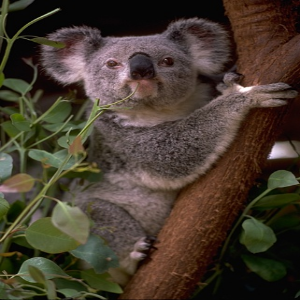

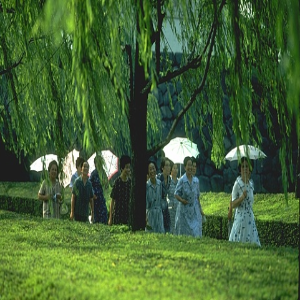

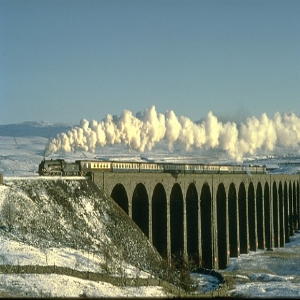

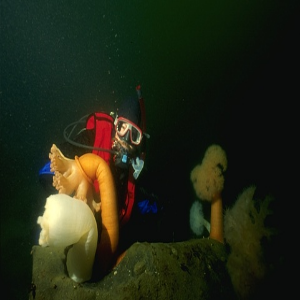

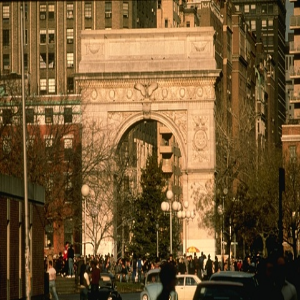

In [11]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))


Creamos el conjunto de testeo

In [12]:
test_path = working_dir + '/Test_Set'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)


In [13]:
# Preprocesamos las imagenes
# Usar TF Ops para procesar.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)


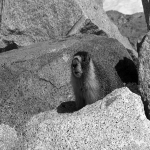

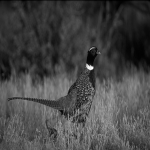

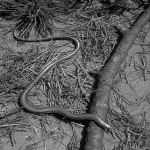

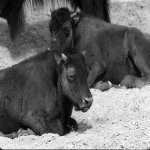

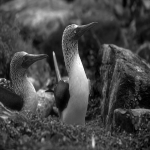

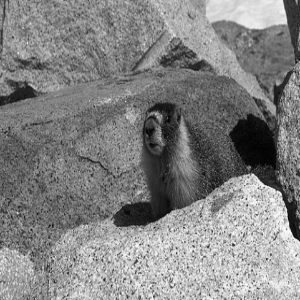

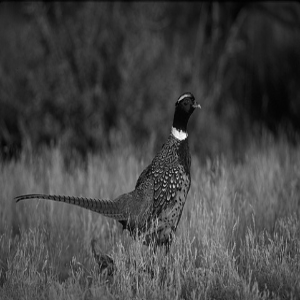

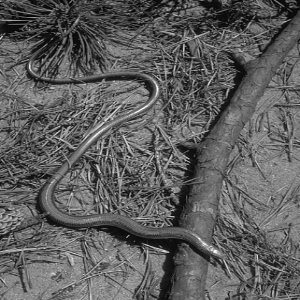

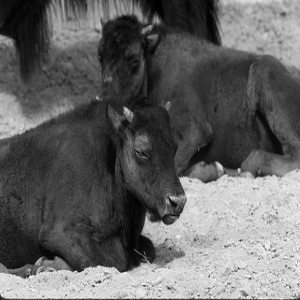

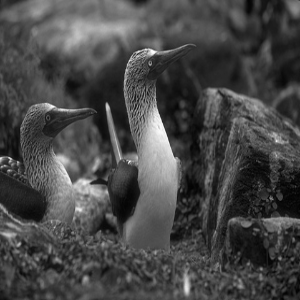

In [14]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


Construimos el modelo

In [15]:
def get_model(upscale_factor=3, channels=1):
    #initializer = tf.random_normal_initializer(0. , 0.02)
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        #"kernel_initializer": initializer,
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 3, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(16, 3, **conv_args)(x)
    x = layers.Conv2DTranspose(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

Definimos funciones de utilidad

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Crear nueva figura
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Especificar los limites.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Aplicar los x-limits.
    axins.set_xlim(x1, x2)
    # Aplicar los y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Dibujar la línea.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restaurar la imagen.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [17]:
# Usamos ESPCN como un callback para imprimir las métricas en cada época.
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Almacenar valor PSNR en cada epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



In [18]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = working_dir + "/Temp"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 4)    580       
 nspose)                                                         
                                                             

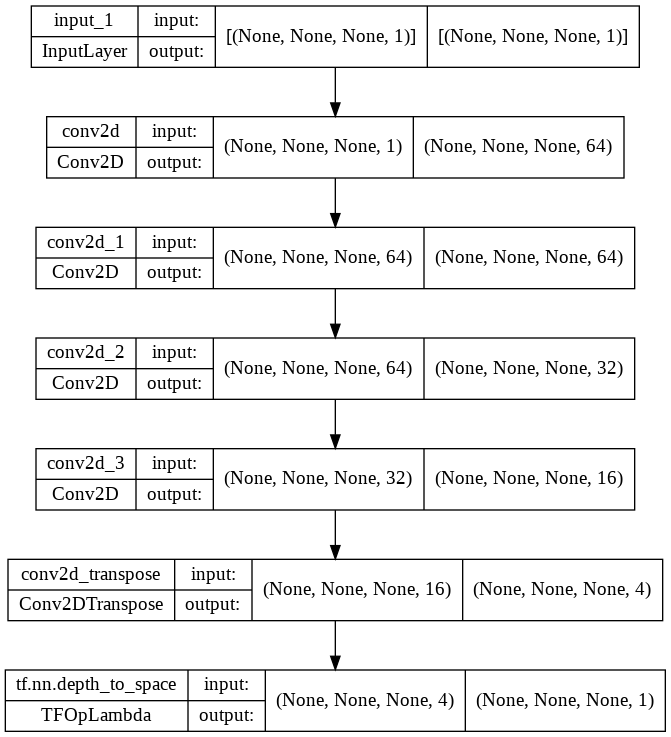

In [19]:
# Graficamos el modelo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Entrenamos el modelo

Epoch 1/150
Mean PSNR for epoch: 7.74


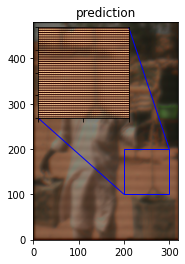

11/11 - 18s - loss: 0.1332 - val_loss: 0.1682 - 18s/epoch - 2s/step
Epoch 2/150
Mean PSNR for epoch: 7.80
11/11 - 1s - loss: 0.1185 - val_loss: 0.1660 - 734ms/epoch - 67ms/step
Epoch 3/150
Mean PSNR for epoch: 8.49
11/11 - 1s - loss: 0.1157 - val_loss: 0.1417 - 623ms/epoch - 57ms/step
Epoch 4/150
Mean PSNR for epoch: 10.44
11/11 - 1s - loss: 0.0741 - val_loss: 0.0904 - 609ms/epoch - 55ms/step
Epoch 5/150
Mean PSNR for epoch: 10.49
11/11 - 1s - loss: 0.0652 - val_loss: 0.0894 - 653ms/epoch - 59ms/step
Epoch 6/150
Mean PSNR for epoch: 10.57
11/11 - 1s - loss: 0.0635 - val_loss: 0.0878 - 625ms/epoch - 57ms/step
Epoch 7/150
Mean PSNR for epoch: 10.63
11/11 - 1s - loss: 0.0621 - val_loss: 0.0865 - 668ms/epoch - 61ms/step
Epoch 8/150
Mean PSNR for epoch: 17.53
11/11 - 1s - loss: 0.0283 - val_loss: 0.0176 - 604ms/epoch - 55ms/step
Epoch 9/150
Mean PSNR for epoch: 19.89
11/11 - 1s - loss: 0.0090 - val_loss: 0.0103 - 609ms/epoch - 55ms/step
Epoch 10/150
Mean PSNR for epoch: 21.08
11/11 - 1s - l

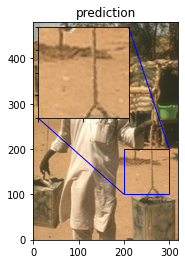

11/11 - 2s - loss: 0.0018 - val_loss: 0.0030 - 2s/epoch - 187ms/step
Epoch 22/150
Mean PSNR for epoch: 25.06
11/11 - 1s - loss: 0.0018 - val_loss: 0.0031 - 704ms/epoch - 64ms/step
Epoch 23/150
Mean PSNR for epoch: 25.27
11/11 - 1s - loss: 0.0022 - val_loss: 0.0030 - 576ms/epoch - 52ms/step
Epoch 24/150
Mean PSNR for epoch: 24.49
11/11 - 1s - loss: 0.0028 - val_loss: 0.0036 - 571ms/epoch - 52ms/step
Epoch 25/150
Mean PSNR for epoch: 25.23
11/11 - 1s - loss: 0.0021 - val_loss: 0.0030 - 565ms/epoch - 51ms/step
Epoch 26/150
Mean PSNR for epoch: 25.22
11/11 - 1s - loss: 0.0019 - val_loss: 0.0030 - 556ms/epoch - 51ms/step
Epoch 27/150
Mean PSNR for epoch: 25.35
11/11 - 1s - loss: 0.0017 - val_loss: 0.0029 - 717ms/epoch - 65ms/step
Epoch 28/150
Mean PSNR for epoch: 25.56
11/11 - 1s - loss: 0.0017 - val_loss: 0.0028 - 623ms/epoch - 57ms/step
Epoch 29/150
Mean PSNR for epoch: 25.60
11/11 - 1s - loss: 0.0016 - val_loss: 0.0028 - 610ms/epoch - 55ms/step
Epoch 30/150
Mean PSNR for epoch: 25.64
11/

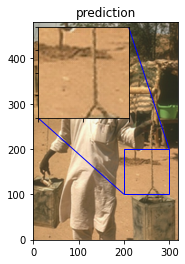

11/11 - 2s - loss: 0.0015 - val_loss: 0.0027 - 2s/epoch - 184ms/step
Epoch 42/150
Mean PSNR for epoch: 25.79
11/11 - 1s - loss: 0.0016 - val_loss: 0.0026 - 615ms/epoch - 56ms/step
Epoch 43/150
Mean PSNR for epoch: 25.71
11/11 - 1s - loss: 0.0016 - val_loss: 0.0027 - 571ms/epoch - 52ms/step
Epoch 44/150
Mean PSNR for epoch: 25.83
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 554ms/epoch - 50ms/step
Epoch 45/150
Mean PSNR for epoch: 25.93
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 672ms/epoch - 61ms/step
Epoch 46/150
Mean PSNR for epoch: 25.90
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 631ms/epoch - 57ms/step
Epoch 47/150
Mean PSNR for epoch: 25.92
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 604ms/epoch - 55ms/step
Epoch 48/150
Mean PSNR for epoch: 25.89
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 641ms/epoch - 58ms/step
Epoch 49/150
Mean PSNR for epoch: 25.95
11/11 - 1s - loss: 0.0015 - val_loss: 0.0025 - 554ms/epoch - 50ms/step
Epoch 50/150
Mean PSNR for epoch: 25.98
11/

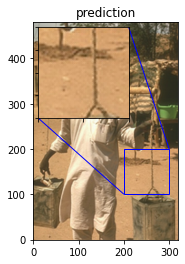

11/11 - 2s - loss: 0.0014 - val_loss: 0.0025 - 2s/epoch - 185ms/step
Epoch 62/150
Mean PSNR for epoch: 25.88
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 652ms/epoch - 59ms/step
Epoch 63/150
Mean PSNR for epoch: 25.93
11/11 - 1s - loss: 0.0015 - val_loss: 0.0026 - 575ms/epoch - 52ms/step
Epoch 64/150
Mean PSNR for epoch: 26.02
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 570ms/epoch - 52ms/step
Epoch 65/150
Mean PSNR for epoch: 26.03
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 565ms/epoch - 51ms/step
Epoch 66/150
Mean PSNR for epoch: 26.04
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 625ms/epoch - 57ms/step
Epoch 67/150
Mean PSNR for epoch: 25.97
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 549ms/epoch - 50ms/step
Epoch 68/150
Mean PSNR for epoch: 26.07
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 654ms/epoch - 59ms/step
Epoch 69/150
Mean PSNR for epoch: 26.09
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 650ms/epoch - 59ms/step
Epoch 70/150
Mean PSNR for epoch: 26.09
11/

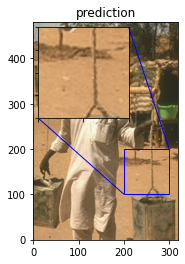

11/11 - 3s - loss: 0.0014 - val_loss: 0.0027 - 3s/epoch - 227ms/step
Epoch 82/150
Mean PSNR for epoch: 26.12
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 651ms/epoch - 59ms/step
Epoch 83/150
Mean PSNR for epoch: 26.13
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 623ms/epoch - 57ms/step
Epoch 84/150
Mean PSNR for epoch: 26.10
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 577ms/epoch - 52ms/step
Epoch 85/150
Mean PSNR for epoch: 26.11
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 575ms/epoch - 52ms/step
Epoch 86/150
Mean PSNR for epoch: 26.10
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 559ms/epoch - 51ms/step
Epoch 87/150
Mean PSNR for epoch: 26.15
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 568ms/epoch - 52ms/step
Epoch 88/150
Mean PSNR for epoch: 26.15
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 641ms/epoch - 58ms/step
Epoch 89/150
Mean PSNR for epoch: 26.16
11/11 - 1s - loss: 0.0014 - val_loss: 0.0024 - 618ms/epoch - 56ms/step
Epoch 90/150
Mean PSNR for epoch: 26.16
11/

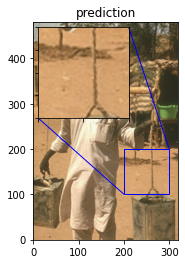

11/11 - 2s - loss: 0.0014 - val_loss: 0.0025 - 2s/epoch - 189ms/step
Epoch 102/150
Mean PSNR for epoch: 26.04
11/11 - 1s - loss: 0.0014 - val_loss: 0.0025 - 576ms/epoch - 52ms/step


In [20]:
epochs = 150

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# Mejores pesos se guardan en el modelo.
model.load_weights(checkpoint_filepath)


Resultados del modelo entrenado

PSNR of low resolution image and high resolution image is 23.2377
PSNR of predict and high resolution is 23.5569


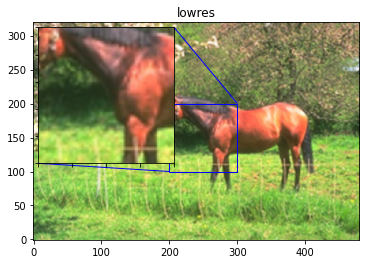

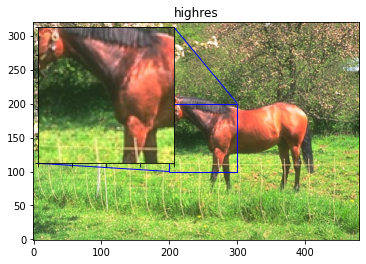

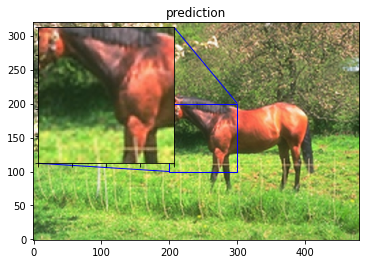

PSNR of low resolution image and high resolution image is 29.7765
PSNR of predict and high resolution is 29.8864


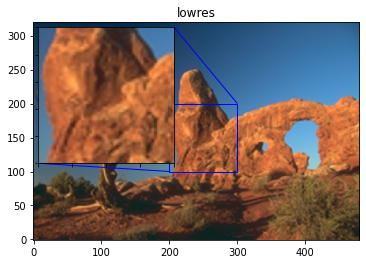

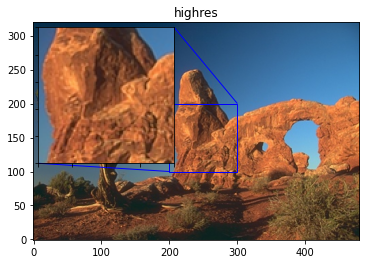

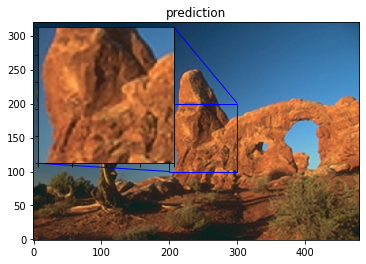

PSNR of low resolution image and high resolution image is 33.9028
PSNR of predict and high resolution is 32.6983


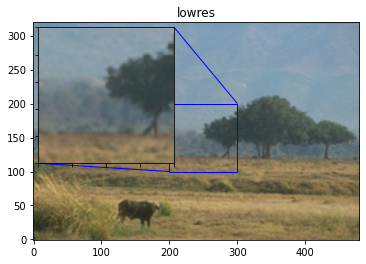

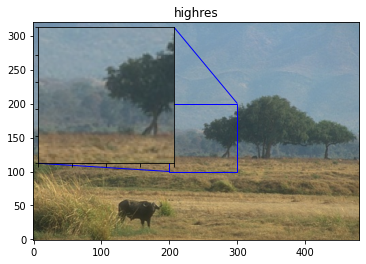

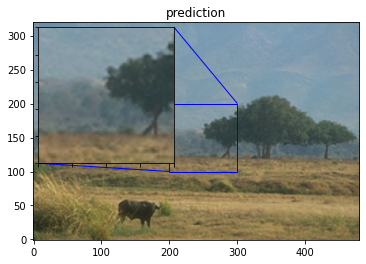

PSNR of low resolution image and high resolution image is 32.2318
PSNR of predict and high resolution is 32.0648


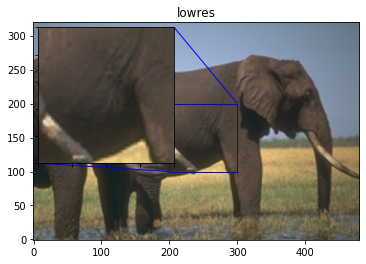

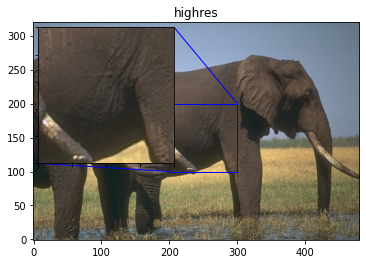

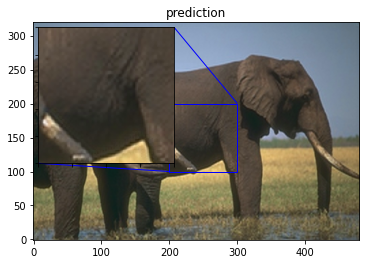

PSNR of low resolution image and high resolution image is 34.1286
PSNR of predict and high resolution is 33.2011


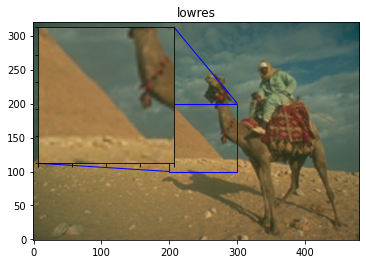

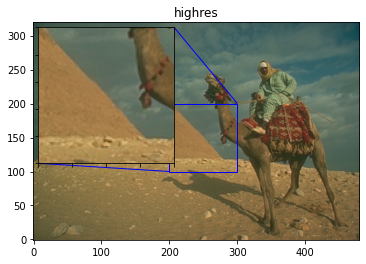

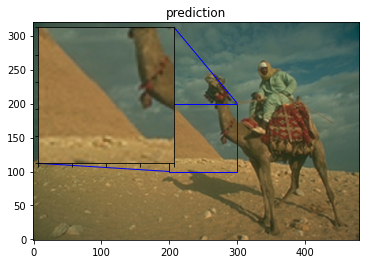

PSNR of low resolution image and high resolution image is 31.0616
PSNR of predict and high resolution is 31.0312


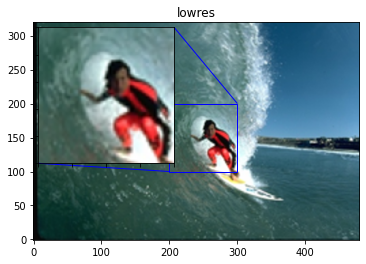

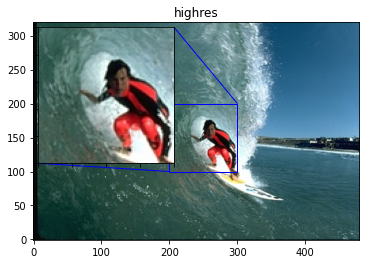

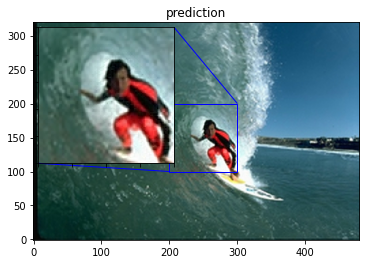

PSNR of low resolution image and high resolution image is 34.1546
PSNR of predict and high resolution is 33.9052


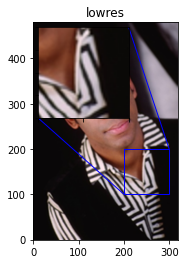

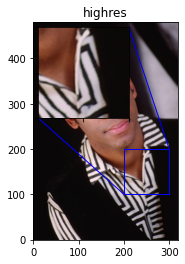

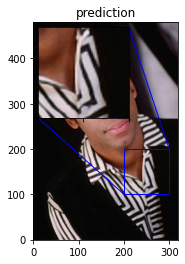

PSNR of low resolution image and high resolution image is 26.8139
PSNR of predict and high resolution is 27.2315


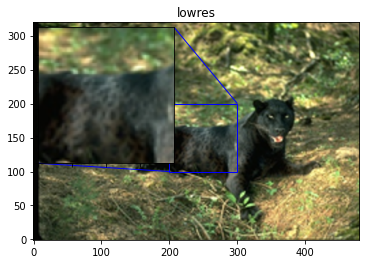

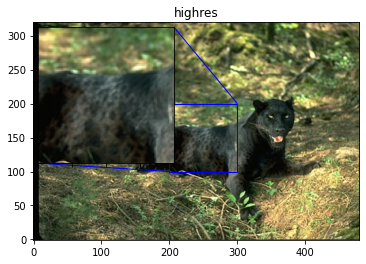

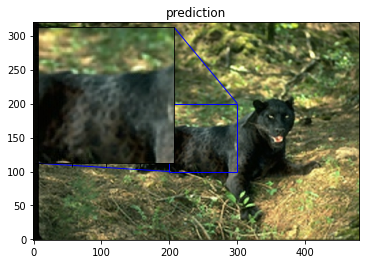

PSNR of low resolution image and high resolution image is 28.3886
PSNR of predict and high resolution is 28.7871


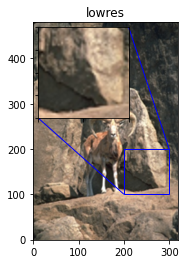

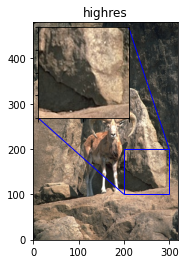

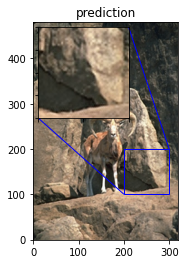

PSNR of low resolution image and high resolution image is 30.9183
PSNR of predict and high resolution is 31.1356


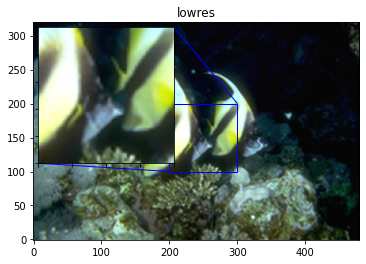

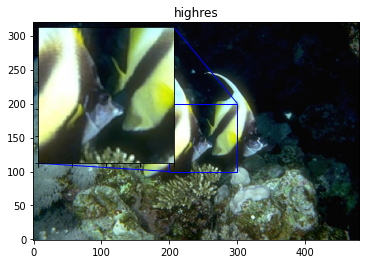

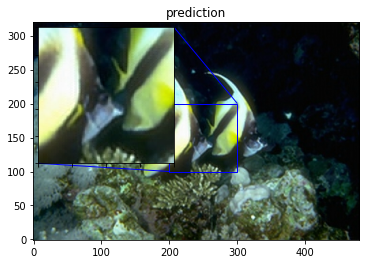

Contador:  10
Avg. PSNR of lowres images is 30.4614
Avg. PSNR of reconstructions is 30.3498


In [21]:
# Resultados del modelo entrenado
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
contador = 0
for index, test_img_path in enumerate(test_img_paths[2:12]):
    contador = contador + 1
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Contador: ", contador)
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / contador))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / contador))

